# Andrew Bui 

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.optim as optim
%matplotlib inline


In [2]:
root = './data'
trans = transforms.ToTensor()
train_set = dset.MNIST(root, train=True,transform=trans,download=True)
test_set = dset.MNIST(root,train=False,transform=trans,download=True)

In [3]:
batch_size = 64
train_loader = DataLoader(train_set,
                          batch_size=batch_size)

test_loader = DataLoader(test_set,
                        batch_size=batch_size)

## 1 & 3

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim,hidden_dim,latent_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) # Assuming MNIST images are 28x28
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, latent_dim)

        self.mu = nn.Linear(latent_dim, latent_dim) # Output 8-dimensional vector of means
        self.sigma = nn.Linear(latent_dim, latent_dim) # Output 8-dimensional vector of positive variances

    def forward(self, x):

        # x = torch.flatten(x, 1)  # Flatten the input
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = torch.relu(self.fc3(x))

        x = F.leaky_relu(self.fc1(x),0.2)
        x = F.leaky_relu(self.fc2(x),0.2)
        x = F.leaky_relu(self.fc3(x),0.2)

        mu = self.mu(x)
        
        sigma = self.sigma(x)

        return  mu, torch.abs(sigma)
    

class Decoder(nn.Module):
    def __init__(self, input_dim,hidden_dim,latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = torch.sigmoid(self.fc3(x))

        x = F.leaky_relu(self.fc1(x),0.2)
        x = F.leaky_relu(self.fc2(x),0.2)
        x = F.sigmoid(self.fc3(x)).to(torch.float)

        return x

In [5]:
# Create an instance of the encoder
encoder = Encoder(input_dim=784,hidden_dim=256, latent_dim=8)
decoder = Decoder(input_dim=784,hidden_dim=256,latent_dim=8)

In [6]:
x = list(train_set)[0][0]

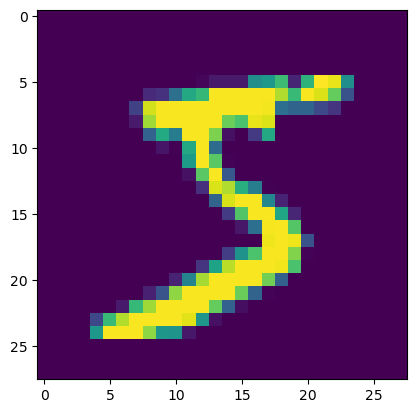

In [7]:
plt.imshow(x.detach().numpy().reshape(28,28));

In [8]:
x = x.view(-1,1,28 * 28)

In [9]:
# Get the means and variances
means, variances = encoder.forward(x)

print("Means:", means)
print("Variances:", variances)

Means: tensor([[[-0.3505, -0.1105,  0.4312,  0.1698, -0.0084,  0.2007,  0.0097,
          -0.4841]]], grad_fn=<ViewBackward0>)
Variances: tensor([[[0.3433, 0.5981, 0.1199, 0.1124, 0.1602, 0.0163, 0.1142, 0.1486]]],
       grad_fn=<AbsBackward0>)


# 2

In [10]:
def generate_sample( mu, sigma):
    # Calculate the standard deviations
    sigma = torch.sqrt(sigma)
    # Generate random epsilon
    eps = torch.randn_like(mu) #  sample from N(0, I)
    # Generate the sample
    sample = mu + sigma * eps
    return sample

In [11]:
sample = generate_sample(means, variances)
sample

tensor([[[-1.3826, -0.9230,  1.0982,  0.6104, -0.2948,  0.2608,  0.0566,
          -0.0377]]], grad_fn=<AddBackward0>)

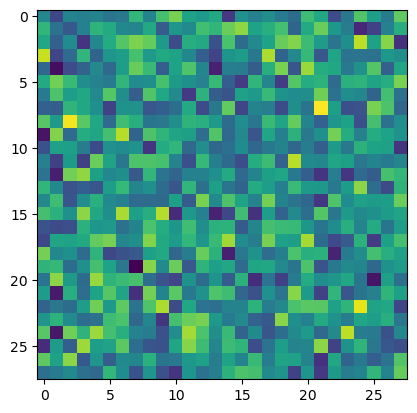

In [12]:
output = decoder(sample)
plt.imshow(output.detach().numpy().reshape(28,28));

# 4

In [13]:
class VAE(nn.Module):
    
    def __init__(self,input_dim=784,hidden_dim= 256, latent_dim=8):
        super().__init__()
        
        self.encoder = Encoder(input_dim,hidden_dim,latent_dim)
        self.decoder = Decoder(input_dim,hidden_dim,latent_dim)
        
    def generate_sample(self, mu, sigma):
        # Calculate the standard deviations
        sigma = torch.sqrt(sigma)
        # Generate random epsilon
        eps = torch.randn_like(mu) #  sample from N(0, I)
        # Generate the sample
        sample = mu + sigma * eps
        return sample
    
    def forward(self,x):
        
        mean, logvar = self.encoder(x)
        
        u = self.generate_sample(mean,torch.exp(logvar))

        z = self.decoder(u)
        
        return z, mean, logvar
    

In [14]:
vae = VAE()
z,mean,logvar = vae(x)

In [15]:
def loss_function(x,z,mean,logvar):
    reconstruction_loss = F.binary_cross_entropy(z,x,reduction='sum')
    KL_div =  - 0.5 * torch.sum(1+ logvar - mean**2 - torch.exp(logvar))
    
    return reconstruction_loss + KL_div

In [16]:
F.binary_cross_entropy(z,x,reduction='sum')

tensor(549.8815, grad_fn=<BinaryCrossEntropyBackward0>)

In [17]:
optimizer = Adam(vae.parameters(),lr=1e-3)

In [18]:
epochs = 50
for e in range(epochs):
    overall_loss = 0.0
    for i,img in enumerate(train_loader):
        
        u = img[0].reshape(-1,28*28)

        z,mean,logvar = vae(u)
        
        optimizer.zero_grad()

        loss = loss_function(u,z,mean,logvar)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", e + 1, "\tAverage Loss: ", overall_loss/(i*batch_size))

	Epoch 1 	Average Loss:  198.71947241491034
	Epoch 2 	Average Loss:  172.16104035596328
	Epoch 3 	Average Loss:  163.08650455861616
	Epoch 4 	Average Loss:  159.94360502196224
	Epoch 5 	Average Loss:  158.53688470276595
	Epoch 6 	Average Loss:  157.54438965755693
	Epoch 7 	Average Loss:  156.92497724046575
	Epoch 8 	Average Loss:  156.35569636162725
	Epoch 9 	Average Loss:  155.93945622724047
	Epoch 10 	Average Loss:  155.51449854473168
	Epoch 11 	Average Loss:  155.25728627533644
	Epoch 12 	Average Loss:  154.9451585686194
	Epoch 13 	Average Loss:  154.81340636718488
	Epoch 14 	Average Loss:  154.6603992995483
	Epoch 15 	Average Loss:  154.45545365080127
	Epoch 16 	Average Loss:  154.33639968497522
	Epoch 17 	Average Loss:  154.1155543210285
	Epoch 18 	Average Loss:  154.0549730038312
	Epoch 19 	Average Loss:  153.7965865567756
	Epoch 20 	Average Loss:  153.75445879892453
	Epoch 21 	Average Loss:  153.67623674195247
	Epoch 22 	Average Loss:  153.53393349499942
	Epoch 23 	Average Loss:

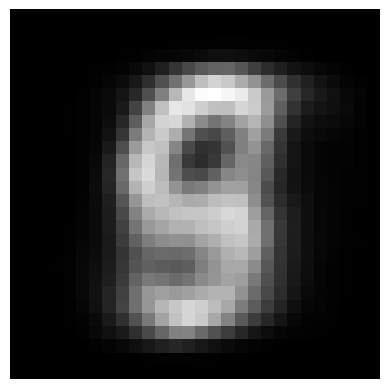

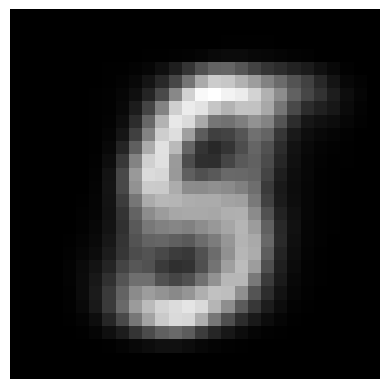

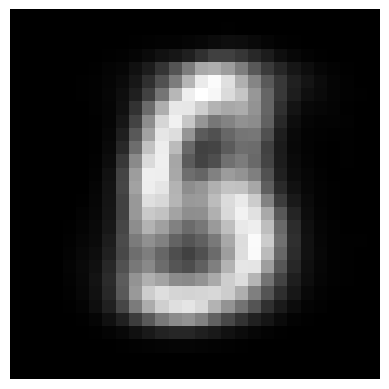

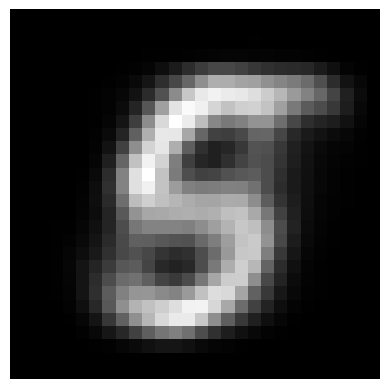

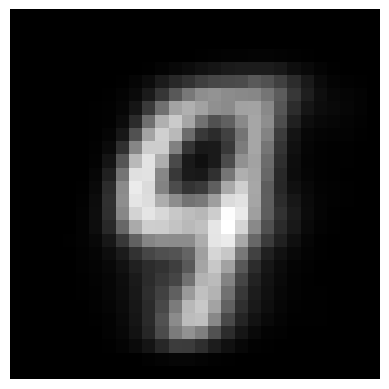

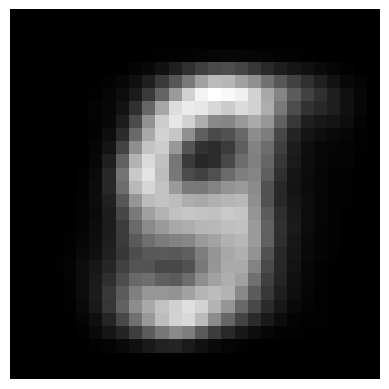

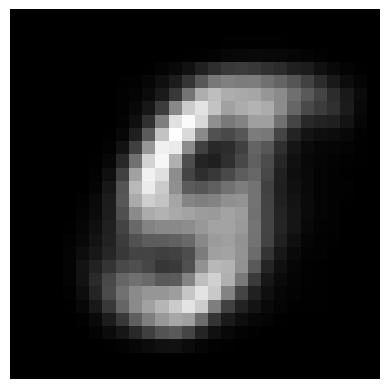

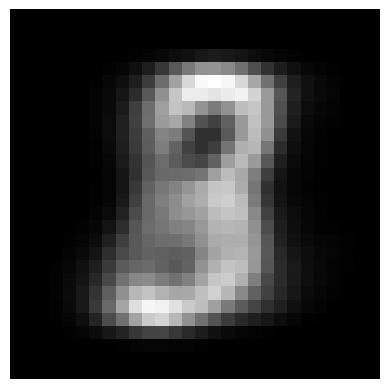

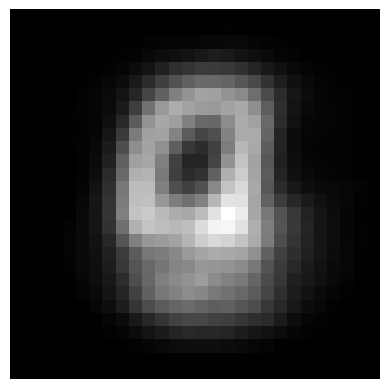

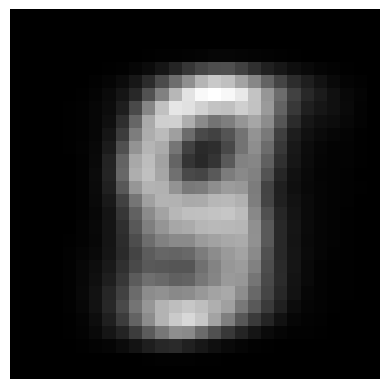

In [19]:
for _ in range(10): 
    means, variances = Encoder(input_dim=784,hidden_dim=256, latent_dim=8).forward(x)       
    z_sample = generate_sample(means, variances)
    x_decoded = vae.decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    # plt.title(f'[{means},{variances}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

In [20]:
# def generate_digit(mean, var):
#     z_sample = torch.tensor([[mean, var]], dtype=torch.float)
#     x_decoded = vae.decoder(z_sample)
#     digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
#     plt.title(f'[{mean},{var}]')
#     plt.imshow(digit, cmap='gray')
#     plt.axis('off')
#     plt.show()

# generate_digit(0.0,1.0)#,generate_digit(1.0,1.0)

In [21]:
def plot_latent_space(model, scale=5.0, n=10, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            means, variances = Encoder(input_dim=784,hidden_dim=256, latent_dim=8).forward(x)       
            z_sample = generate_sample(means, variances)
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

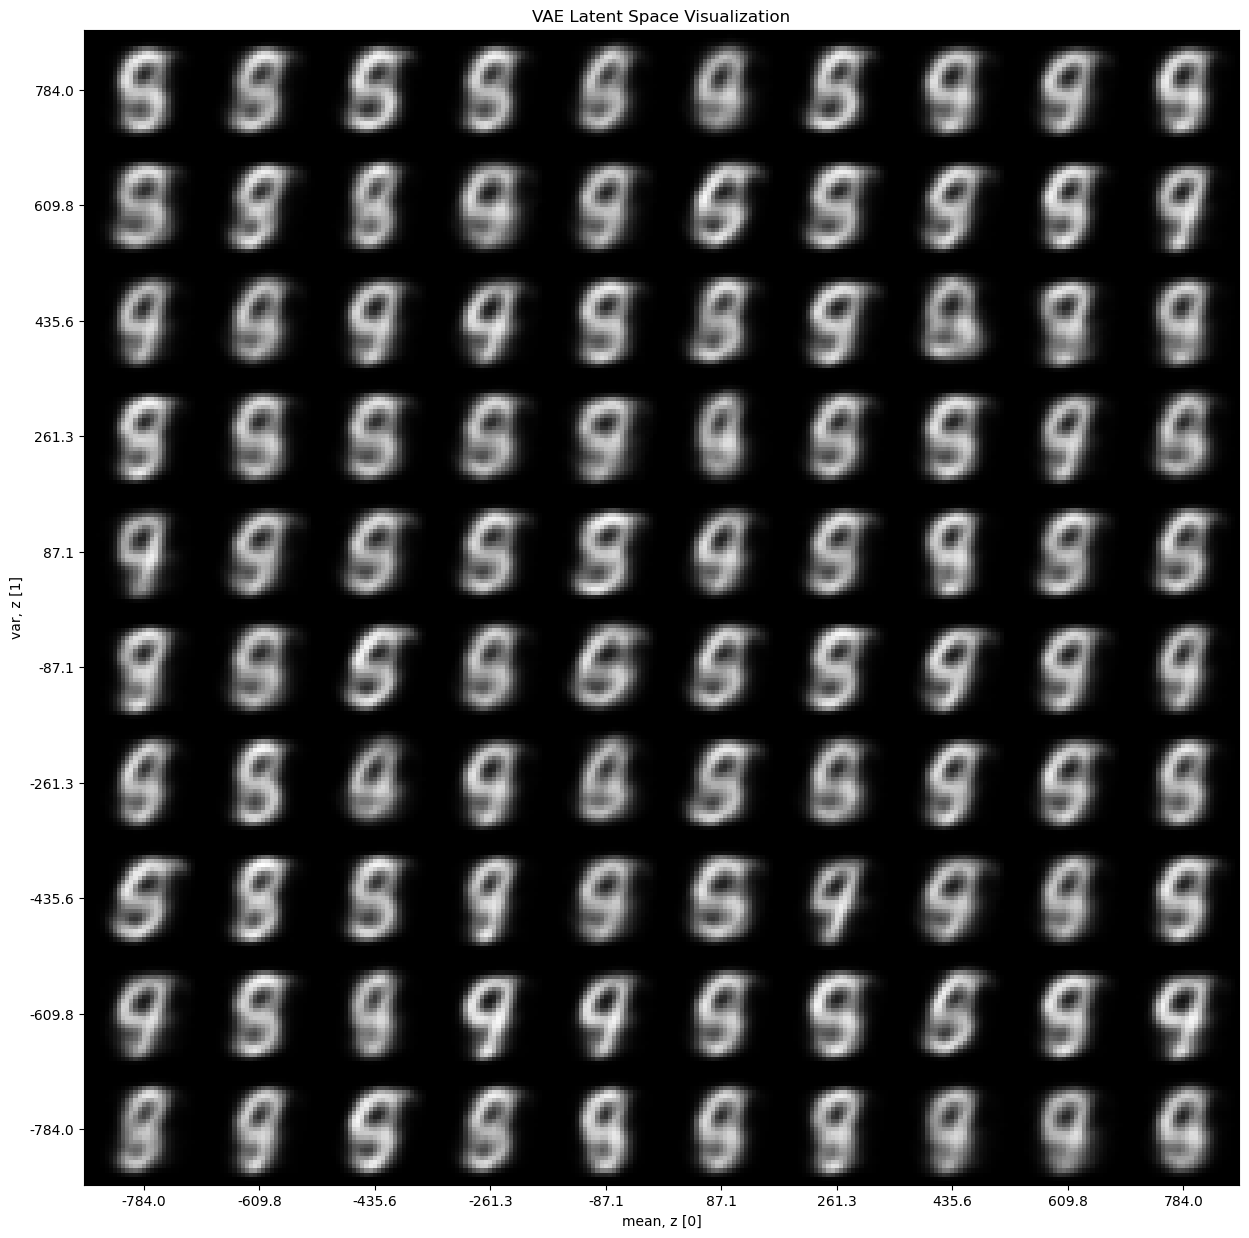

In [22]:
plot_latent_space(vae, scale=784.0)